# Decision Analysis

## The Price Is Right Problem

## The Prior

In [1]:
include("utils.jl"); using .Utils
checkpkgs("DataFrames", "CSV", "KernelDensity", "Plots", "LaTeXStrings", "Statistics", "Distributions")

getfile("https://raw.githubusercontent.com/AllenDowney/ThinkBayes2/master/data/showcases.2011.csv")
getfile("https://raw.githubusercontent.com/AllenDowney/ThinkBayes2/master/data/showcases.2012.csv")

In [2]:
using DataFrames
import CSV

"""Read the showcase price data."""
function read_data(filename)
    df = CSV.File(filename, skipto=3) |> DataFrame |> dropmissing
    col_names=df[!, 1]
    return transpose(df[!, 2:end]; col_names)
end

read_data

In [3]:
df2011 = read_data("showcases.2011.csv")
df2012 = read_data("showcases.2012.csv")

df = [df2011; df2012];

In [4]:
println(size(df2011), " ", size(df2012), " ", size(df))

(191, 6) (122, 6) (313, 6)


In [5]:
first(df, 3)

,Showcase 1,Showcase 2,Bid 1,Bid 2,Difference 1,Difference 2
,Int64,Int64,Int64,Int64,Int64,Int64
1,50969,45429,42000,34000,8969,11429
2,21901,34061,14000,59900,7901,-25839
3,32815,53186,32000,45000,815,8186


## Kernel Density Estimation

In [6]:
include("empiricaldist.jl"); using .EmpiricalDist

using KernelDensity

# renaming: kde_from_sample is defined in empiricaldist
"""Make a kernel density estimate from a sample."""
function my_kde_from_sample(sample, qs)
    ps = pdf(InterpKDE(kde(sample)), qs)
    pmf = Pmf(ps, qs)
    normalize!(pmf)
    return pmf
end

my_kde_from_sample

In [7]:
qs = LinRange(0, 80000, 81)
prior1 = my_kde_from_sample(df[!,"Showcase 1"], qs);

In [8]:
function decorate_value!(title="")
    xlabel!("Showcase value (\$\$)")
    ylabel!("PMF")
    plot!(formatter=:plain)
    title!(title)
end

decorate_value! (generic function with 2 methods)

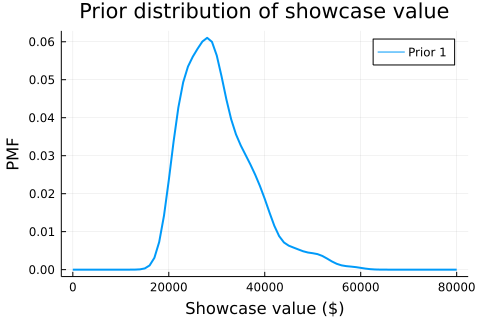

In [9]:
using Plots

plot(prior1, label="Prior 1",)
decorate_value!("Prior distribution of showcase value")

In [10]:
# 9.1

qs = LinRange(0, 80000, 81)
prior2 = my_kde_from_sample(df[!,"Showcase 2"], qs);

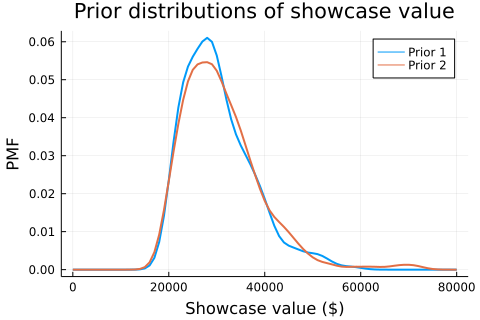

In [11]:
plot(prior1, label="Prior 1")
plot!(prior2, label="Prior 2")
decorate_value!("Prior distributions of showcase value")

## Distribution of Error

In [12]:
sample_diff1 = df[!, "Bid 1"] - df[!, "Showcase 1"]
sample_diff2 = df[!, "Bid 2"] - df[!, "Showcase 2"];

In [13]:
qs = LinRange(-40000, 20000, 61)
kde_diff1 = my_kde_from_sample(sample_diff1, qs)
kde_diff2 = my_kde_from_sample(sample_diff2, qs);

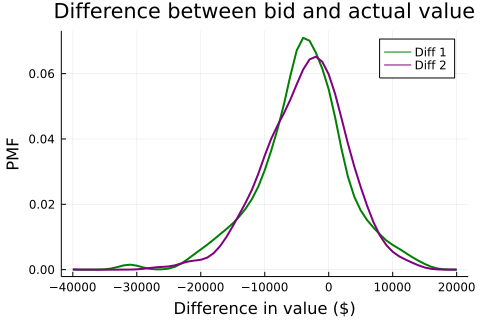

In [14]:
using Plots

plot(kde_diff1, label="Diff 1", color=:green, formatter=:plain)
plot!(kde_diff2, label="Diff 2", color=:purple)

xlabel!("Difference in value (\$\$)")
ylabel!("PMF")
title!("Difference between bid and actual value")

In [15]:
using Statistics

mean_diff1 = mean(sample_diff1)
std_diff1 = std(sample_diff1)

mean_diff1, std_diff1

(-4116.3961661341855, 6899.909806377115)

In [16]:
using Distributions

error_dist1 = Normal(0, std_diff1)

Normal{Float64}(μ=0.0, σ=6899.909806377115)

In [17]:
err = -100
pdf(error_dist1, err)

5.7812405640086924e-5

## Update

In [18]:
guess1 = 23000
error1 = guess1 .- prior1.qs;

In [19]:
likelihood1 = pdf(error_dist1, error1);

In [20]:
posterior1 = prior1 .* likelihood1
normalize!(posterior1)

3.4031737243067566e-5

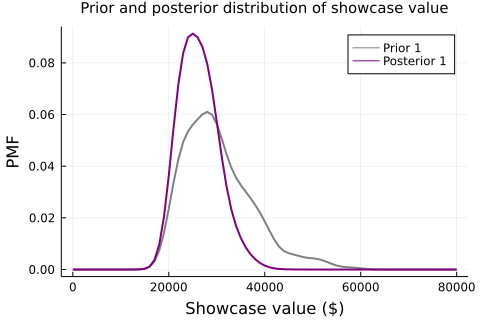

In [21]:
plot(prior1, label="Prior 1", color=:gray)
plot!(posterior1, label="Posterior 1", color=:purple, titlefontsize=10)
decorate_value!("Prior and posterior distribution of showcase value")

In [22]:
mean(prior1), mean(posterior1)

(30299.500051878364, 26225.74424856521)

In [23]:
# 9.2

mean_diff2 = mean(sample_diff2)
std_diff2 = std(sample_diff2)

mean_diff2, std_diff2

(-3675.891373801917, 6886.26071132341)

In [24]:
error_dist2 = Normal(0, std_diff2)

Normal{Float64}(μ=0.0, σ=6886.26071132341)

In [25]:
guess2 = 38000
error2 = guess2 .- prior2.qs

likelihood2 = pdf(error_dist2, error2);

In [26]:
posterior2 = prior2 .* likelihood2
normalize!(posterior2)

2.702402351029367e-5

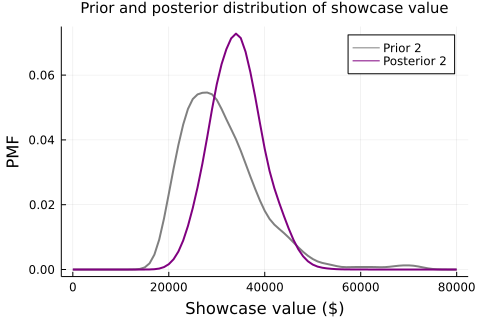

In [27]:
plot(prior2, label="Prior 2", color=:gray)
plot!(posterior2, label="Posterior 2", titlefontsize=10, color=:purple)

decorate_value!("Prior and posterior distribution of showcase value")

In [28]:
mean(prior2), mean(posterior2)

(31047.681514472384, 34204.3871786929)

## Probability of Winning

In [29]:
"""Compute the probability of an overbid."""
prob_overbid(sample_diff) = mean(sample_diff .> 0)

prob_overbid

In [30]:
prob_overbid(sample_diff2)

0.29073482428115016

In [31]:
"""Probability opponent diff is worse than given diff."""
prob_worse_than(diff, sample_diff) = mean(sample_diff .< diff)

prob_worse_than

In [32]:
prob_worse_than(-5000, sample_diff2)

0.38338658146964855

In [33]:
prob_worse_than(-10000, sample_diff2)

0.14376996805111822

In [34]:
"""Probability of winning for a given diff."""
function compute_prob_win(diff, sample_diff)
    # if you overbid you lose
    if diff > 0
        return 0
    end
    
    # if the opponent overbids, you win
    p1 = prob_overbid(sample_diff)
    
    # or of their bid is worse than yours, you win
    p2 = prob_worse_than(diff, sample_diff)
    
    # p1 and p2 are mutually exclusive, so we can add them
    return p1 + p2
end

compute_prob_win

In [35]:
compute_prob_win(-5000, sample_diff2)

0.6741214057507987

In [36]:
xs = LinRange(-30000, 5000, 121)
ys = [compute_prob_win(x, sample_diff2) 
      for x in xs];

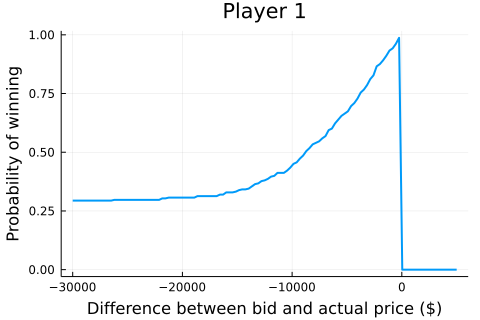

In [37]:
plot(xs, ys, formatter=:plain)

xlabel!("Difference between bid and actual price (\$\$)")
ylabel!("Probability of winning")
title!("Player 1")

In [38]:
# 9.3

prob_overbid(sample_diff1)

0.24600638977635783

In [39]:
prob_worse_than(-5000, sample_diff1)

0.3993610223642173

In [40]:
compute_prob_win(-5000, sample_diff1)

0.6453674121405751

In [41]:
xs = LinRange(-30000, 5000, 121)
ys = [compute_prob_win(x, sample_diff1) for x in xs];

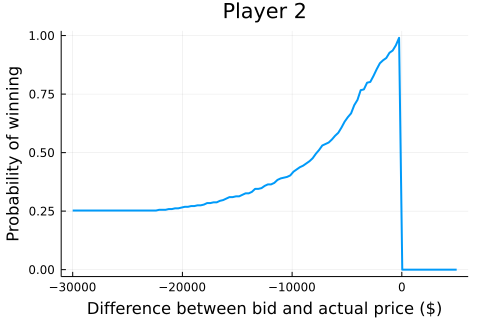

In [42]:
plot(xs, ys, formatter=:plain)

xlabel!("Difference between bid and actual price (\$\$)")
ylabel!("Probability of winning")
title!("Player 2")

## Decision Analysis

In [43]:
"""Computes the total probability of winning with a given bid.

bid: your bid
posterior: Pmf of showcase value
sample_diff: sequence of differences for the opponent

returns: probability of winning
"""
function total_prob_win(bid, posterior, sample_diff)
    total = 0
    for (price, prob) in pairs(posterior)
        diff = bid .- price
        total += prob .* compute_prob_win(diff, sample_diff)
    end
    return total
end

total_prob_win

In [44]:
total_prob_win(25000, posterior1, sample_diff2)

0.4858350296377598

In [45]:
bids = posterior1.qs

probs = [total_prob_win(bid, posterior1, sample_diff2) 
         for bid in bids]

# DataFrames doesn't have something similar to pd.Series
# we'll use DataFrame instead, and create an helper function to fill 
# a DataFrame with explicit `index` (`bids`) column and with the data (`probs` here) 
# in a `values` column

make_series(d, v) = DataFrame(index=d, values=v);
prob_win_series = make_series(bids, probs);

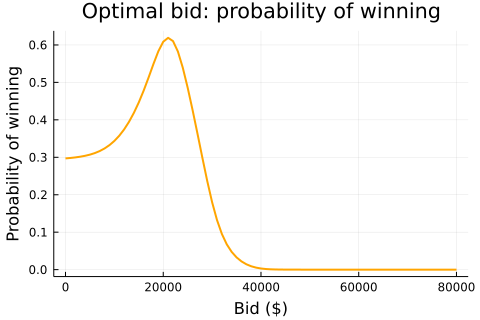

In [46]:
using StatsPlots

# let's also create an helper function to plot this type of dataframe
function plot_series(df; kwargs...)
    @df df plot(:index, :values; kwargs...)
end

plot_series(prob_win_series, label="Player 1", color=:orange, formatter=:plain)
xlabel!("Bid (\$\$)")
ylabel!("Probability of winning")
title!("Optimal bid: probability of winning")

In [47]:
# this is a bit convoluted...
idxmax(df) = df.index[argmax(df.values)]

idxmax(prob_win_series)

21000.0

In [48]:
max(df) = maximum(df.values)

max(prob_win_series)

0.6189950034107672

In [49]:
bids = posterior2.qs

probs = [total_prob_win(bid, posterior2, sample_diff1) 
         for bid in bids]

prob_win_series = make_series(bids, probs);

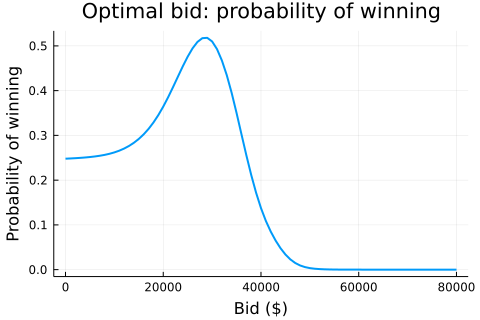

In [50]:
plot_series(prob_win_series, label="Player 2", formatter=:plain)

xlabel!("Bid (\$\$)")
ylabel!("Probability of winning")
title!("Optimal bid: probability of winning")

In [51]:
idxmax(prob_win_series)

29000.0

In [52]:
max(prob_win_series)

0.5180120737778849

## Maximizing Expected Gain

In [53]:
"""Compute expected gain given a bid and actual price."""
function compute_gain(bid, price, sample_diff)
    diff = bid - price
    prob = compute_prob_win(diff, sample_diff)

    # if you are within 250 dollars, you win both showcases
    if -250 <= diff <= 0
        return 2 .* price .* prob
    else
        return price .* prob
    end
end

compute_gain

In [54]:
compute_gain(30000, 35000, sample_diff2)

23594.249201277955

In [55]:
"""Compute the expected gain of a given bid."""
function expected_gain(bid, posterior, sample_diff)
    total = 0
    for (price, prob) in pairs(posterior)
        total += prob .* compute_gain(bid, price, sample_diff)
    end
    return total
end

expected_gain

In [56]:
expected_gain(21000, posterior1, sample_diff2)

17060.468359428414

In [57]:
bids = posterior1.qs

gains = [expected_gain(bid, posterior1, sample_diff2) for bid in bids]

expected_gain_series = make_series(bids, gains);

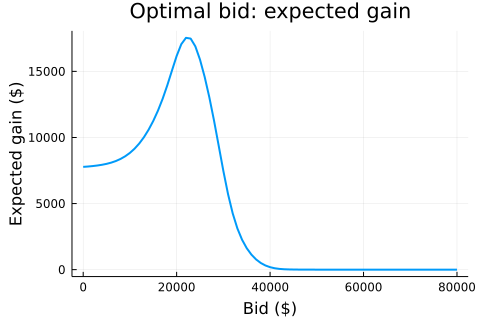

In [58]:
plot_series(expected_gain_series, label="Player 1", formatter=:plain)

xlabel!("Bid (\$\$)")
ylabel!("Expected gain (\$\$)")
title!("Optimal bid: expected gain")

In [59]:
idxmax(expected_gain_series)

22000.0

In [60]:
max(expected_gain_series)

17539.755061261556

In [61]:
bids = posterior2.qs

gains = [expected_gain(bid, posterior2, sample_diff1) for bid in bids]

expected_gain_series = make_series(bids, gains);

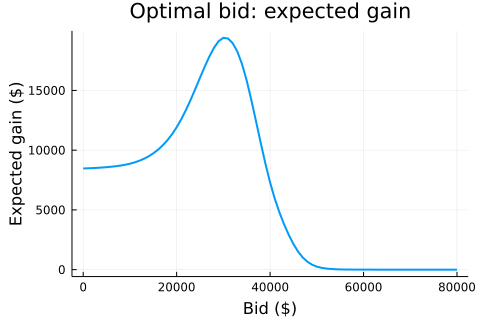

In [62]:
plot_series(expected_gain_series, label="Player 2", formatter=:plain)

xlabel!("Bid (\$\$)")
ylabel!("Expected gain (\$\$)")
title!("Optimal bid: expected gain")

In [63]:
idxmax(expected_gain_series)

30000.0

In [64]:
max(expected_gain_series)

19403.971772904257

## Summary

## Discussion

## Exercises

In [65]:
# 9.7

"""Compute print costs.

printed: integer number printed
"""
function print_cost(printed)
    if printed < 100
        return printed * 5
    else
        return printed * 4.5
    end
end

print_cost

In [66]:
"""Compute income.

printed: integer number printed
orders: sequence of integer number of books ordered
"""
function total_income(printed, orders)
    sold = min(printed, sum(orders))
    return sold * 10
end

total_income

In [67]:
"""Compute inventory costs.

printed: integer number printed
orders: sequence of integer number of books ordered
"""
function inventory_cost(printed, orders)
    excess = printed - sum(orders)
    if excess > 0
        return excess * 2
    else
        return 0
    end
end

inventory_cost

In [68]:
"""Compute out of stock costs.

printed: integer number printed
orders: sequence of integer number of books ordered
"""
function out_of_stock_cost(printed, orders)
    weeks = length(orders)
    total_orders = cumsum(orders)
    for (i, total) in enumerate(total_orders)
        if total > printed
            return (weeks-i+1) * 50 # 1-based
        end
    end
    return 0
end

out_of_stock_cost

In [69]:
"""Compute profit.

printed: integer number printed
orders: sequence of integer number of books ordered
"""
function compute_profit(printed, orders)
    return (total_income(printed, orders) -
            print_cost(printed)-
            out_of_stock_cost(printed, orders) -
            inventory_cost(printed, orders))
end

compute_profit

In [70]:
always_10 = repeat([10], 8)
always_10;

In [71]:
compute_profit(60, always_10)

200

In [72]:
compute_profit(100, always_10)

310.0

In [73]:
alpha = 9
qs = LinRange(0, 25, 101)
ps = pdf.(Gamma.(alpha), qs)
pmf = Pmf(ps, qs)
normalize!(pmf)
mean(pmf)

8.998788382371904

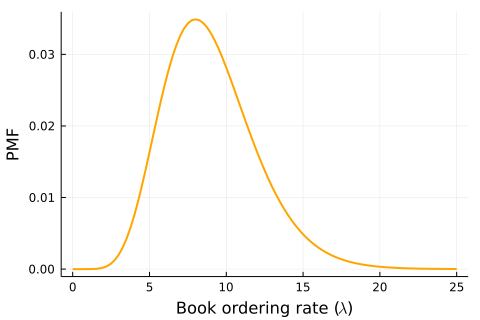

In [74]:
using LaTeXStrings
plot(pmf, color=:orange)
xlabel!(L"Book ordering rate ($\lambda$)")
ylabel!("PMF")

In [75]:
rates = sample(pmf, 1000)
mean(rates)

9.0495

In [76]:
import Random
Random.seed!(17)

order_array = [rand(Poisson(r)) for r=rates, _=1:8]
order_array[1:5, :]

5×8 Matrix{Int64}:
 11  12   6  18  10  20   9  13
 11  13   9  15   5  10  16   5
 13  10  15  12  13  10  11  13
  8  10   5   6   7   9   7   7
 16  10   6  14   6   8   9   6

In [77]:
"""Compute profits averaged over a sample of orders.

printed: number printed
order_array: one row per sample, one column per week
"""
function compute_expected_profits(printed, order_array)
    profits = [compute_profit(printed, orders)
               for orders in eachrow(order_array)]
    return mean(profits)
end

compute_expected_profits

In [78]:
compute_expected_profits(70, order_array)

187.508

In [79]:
compute_expected_profits(80, order_array)

187.344

In [80]:
compute_expected_profits(90, order_array)

164.442

In [81]:
printed_array = 70:109
t = [compute_expected_profits(printed, order_array)
                    for printed in printed_array]
expected_profits = make_series(printed_array, t);

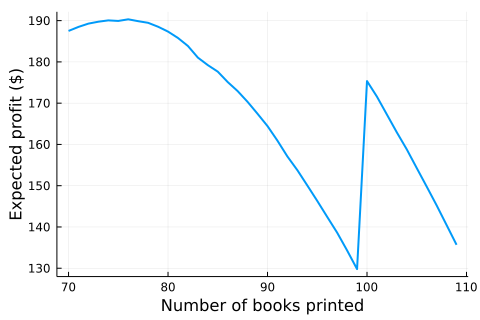

In [82]:
plot_series(expected_profits, label="")

xlabel!("Number of books printed")
ylabel!("Expected profit (\$\$)")

In [83]:
idxmax(expected_profits), max(expected_profits)

(76, 190.324)

In [84]:
qs = exp10.(range(0, 2, length=101))
prior = Pmf(1, qs)
normalize!(prior)

101.0

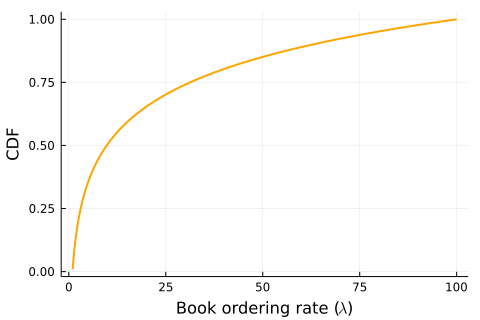

In [85]:
plot(makecdf(prior), color=:orange)
xlabel!(L"Book ordering rate ($\lambda$)")
ylabel!("CDF")

In [86]:
"""Update book ordering rate.

pmf: Pmf of book ordering rates
data: observed number of orders in one week
"""
function update_book!(pmf, data)
    k = data
    lams = keys(pmf)
    likelihood = pdf.(Poisson.(lams), k)
    pmf .*= likelihood
    normalize!(pmf)
end

update_book!

In [87]:
posterior1 = copy(prior)
update_book!(posterior1, 10)

0.021499724898573287

In [88]:
posterior2 = copy(posterior1)
update_book!(posterior2, 9)

0.09273529884477551

In [89]:
mean(prior), mean(posterior1), mean(posterior2)

(21.788491074586535, 10.000000817984523, 9.500000000003656)

In [90]:
rates = sample(posterior2,1000)
mean(rates)

9.56610547783935

In [91]:
order_array = [rand(Poisson(r)) for r=rates, _=1:8]
order_array[1:5, :]

5×8 Matrix{Int64}:
  4   4  14   7   9  13  16  12
  5  10   3   9   5   7   6   5
  8   9  11   9  11   7   7   8
  8   7   7   4   8   4   7  12
 10  10   7  10   7   7   9   9

In [92]:
printed_array = 70:109
t = [compute_expected_profits(printed, order_array)
                    for printed in printed_array]
expected_profits = make_series(printed_array, t);

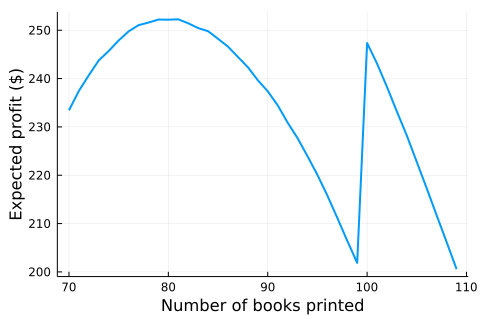

In [93]:
plot_series(expected_profits, label="")

xlabel!("Number of books printed")
ylabel!("Expected profit (\$\$)")

In [94]:
idxmax(expected_profits)

81